In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
%cd ../gdrive/MyDrive/CSE_575/

/gdrive/MyDrive/CSE_575


In [3]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, Activation 
from sklearn.metrics import classification_report as cr, confusion_matrix as cm

In [4]:
# Helper Functions
def load_data():
    ohe = OneHotEncoder(sparse_output=False)
    X = np.load("X.npy")[:,:,:,:3]
    y = np.load("y.npy")
    y = ohe.fit_transform(y.reshape(-1,1))
    labels = ohe.categories_[0]
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=0)
    return X_train, X_test, y_train, y_test, labels

In [5]:
# Loading Data
X_train, X_test, y_train, y_test, labels = load_data()

In [6]:
# Model Definition
model_layers = [
    Conv2D(64, (3, 3), input_shape=(288, 432, 3)),
    MaxPool2D(pool_size=(3, 3)),

    Conv2D(32, (3, 3)),
    MaxPool2D(pool_size=(3, 3)),

    Conv2D(32, (3, 3)),
    MaxPool2D(pool_size=(3, 3)),

    Dropout(0.3),
    Flatten(),

    Dense(10, activation="softmax")
]

model = Sequential(model_layers)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 286, 430, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 95, 143, 64)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 93, 141, 32)       18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 45, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 15, 32)        0

In [7]:
# Model Training
model.fit(X_train, y_train, batch_size=10, epochs=20, validation_split=0.2)
print(f"Model Performance on Training Data: {model.evaluate(X_train,y_train)}")

Epoch 1/20
64/64 [==============================] - 17s 93ms/step - loss: 2.2052 - accuracy: 0.1862 - val_loss: 2.0829 - val_accuracy: 0.2250
Epoch 2/20
64/64 [==============================] - 4s 67ms/step - loss: 1.8332 - accuracy: 0.3302 - val_loss: 1.6442 - val_accuracy: 0.4062
Epoch 3/20
64/64 [==============================] - 4s 67ms/step - loss: 1.4722 - accuracy: 0.4648 - val_loss: 1.4878 - val_accuracy: 0.4625
Epoch 4/20
64/64 [==============================] - 5s 70ms/step - loss: 1.1754 - accuracy: 0.5978 - val_loss: 1.5279 - val_accuracy: 0.4812
Epoch 5/20
64/64 [==============================] - 4s 68ms/step - loss: 1.0959 - accuracy: 0.6291 - val_loss: 1.3818 - val_accuracy: 0.5375
Epoch 6/20
64/64 [==============================] - 4s 67ms/step - loss: 0.8666 - accuracy: 0.7261 - val_loss: 1.3270 - val_accuracy: 0.5750
Epoch 7/20
64/64 [==============================] - 5s 75ms/step - loss: 0.7353 - accuracy: 0.7543 - val_loss: 1.6551 - val_accuracy: 0.4625
Epoch 8/20
6

In [8]:
pred = model.predict(X_test)
pred = (pred>0.5)

print(cr(y_test,pred))
conf_m = cm(np.argmax(y_test,axis=1),np.argmax(pred,axis=1))
print(conf_m)

7/7 [==============================] - 1s 85ms/step
              precision    recall  f1-score   support

           0       0.45      0.71      0.56        14
           1       0.79      1.00      0.88        11
           2       0.61      0.54      0.57        26
           3       0.60      0.62      0.61        24
           4       0.81      0.63      0.71        27
           5       0.82      0.88      0.85        16
           6       1.00      0.83      0.91        18
           7       0.80      0.35      0.48        23
           8       0.83      0.48      0.61        21
           9       0.50      0.65      0.57        20

   micro avg       0.69      0.64      0.66       200
   macro avg       0.72      0.67      0.67       200
weighted avg       0.72      0.64      0.66       200
 samples avg       0.64      0.64      0.64       200

[[10  0  2  1  0  0  0  0  0  1]
 [ 0 11  0  0  0  0  0  0  0  0]
 [ 5  1 14  0  0  3  0  0  0  3]
 [ 4  0  1 15  2  0  0  0  0  2]
 [ 

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


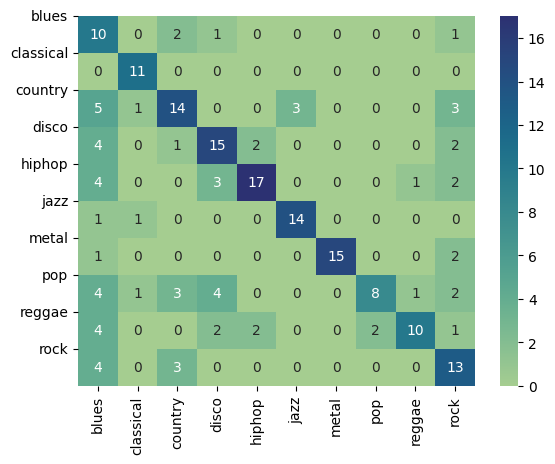

In [9]:
import seaborn as sns
from seaborn import heatmap
heatmap(conf_m,cmap="crest",annot=True)
plt.xticks(ticks = np.arange(0.5,10,1), labels=labels, rotation=90)
plt.yticks(ticks = np.arange(0,10,1), labels=labels,rotation=0)
plt.show()

In [10]:
class_acc = conf_m.diagonal()/conf_m.sum(axis=1)
for i in range(len(labels)):
  print(f"Class Accuracy for {labels[i]}: {round(class_acc[i],2)}")
print(f"\n**Total Accuracy : {np.trace(conf_m)/np.sum(conf_m)}**")

Class Accuracy for blues: 0.71
Class Accuracy for classical: 1.0
Class Accuracy for country: 0.54
Class Accuracy for disco: 0.62
Class Accuracy for hiphop: 0.63
Class Accuracy for jazz: 0.88
Class Accuracy for metal: 0.83
Class Accuracy for pop: 0.35
Class Accuracy for reggae: 0.48
Class Accuracy for rock: 0.65

**Total Accuracy : 0.635**
